# Project overview 

The project is about borrowers loan history. We have to create a scoring model to predict if the loan is given or not depending on the data provided. 
The dataset is available here - https://www.kaggle.com/c/home-credit-default-risk/abs

# Importing relevant libraries

In [99]:
#importing datasets and performaing numerical operations
import pandas as pd
import numpy as np
#data visualization
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.graph_objects as go
#standerdization, label encoding and train-test split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
#Machine Learning Models and hyperparameters tuning
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
#accuracy and precision recall curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
#roc curve, score, confusion matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score
#handling warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#set display max column to see all column
pd.set_option("display.max_columns", None)
pd.get_option("display.max_columns")

#set display max column to see all column
pd.set_option("display.max_rows", 150)
pd.get_option("display.max_rows")

150

# Dataset Loading

In [3]:
#the provided data folder contains various .csv files related to the borrower and also the train and 
#test files for the model bulding. We have mainly focussed on train and test files for exploration, 
#cleaning and model building
data_train = pd.read_csv('application_train.csv')#loading the train data
data_train.head(3)#gives the first three lines of the dataset

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120          NaN           1               1                0   
1             -291          NaN           1               1                0   
2            -2531         26.0           1               1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0                 1           1           0        Laborers              1.0   
1                 1           1           0      Core staff              2.0   
2                 1           1           0        Laborers              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  \
0                       0                        0  Business Entity Type 3   
1                       0                        0                  School   
2                       0                        0              Government   

   EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.083037      0.262949      0.139376          0.0247            0.0369   
1      0.311267      0.622246           NaN          0.0959            0.0529   
2           NaN      0.555912      0.729567             NaN               NaN   

   YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  \
0                       0.9722           0.6192          0.0143   
1                       0.9851           0.7960          0.0605   
2                          NaN              NaN             NaN   

   ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  \
0     

In [4]:
data_train.shape # rows and numbers of columns respectively in the dataset

(307511, 122)

In [5]:
data_train.info() # number of dtypes of columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


# Data Exploration and Preprocessing


## Investigating TARGET column

In [6]:
#TARGET is a dependent data (label) in training data. 0 represent good debtor and 1 represent bad debtor
data_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

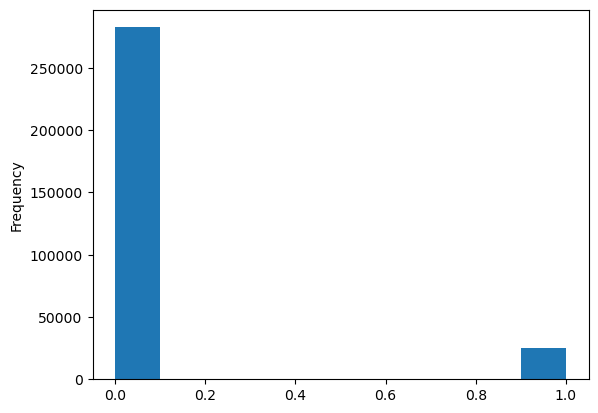

In [7]:
data_train['TARGET'].astype(int).plot.hist();# we can see that the target column is highly imbalanced.
#Most of data contain good debtor labeled data (0).

## Handling missing values


In [8]:
#the function converts the null values to the dataframe
def missing_val(df):
    null_values = pd.DataFrame((df.isna().sum())/df.shape[0]).sort_values(by=0, ascending=False)
    null_values["Col"] = null_values.index
    null_values = null_values.rename(columns={0:"%null"})
    return null_values

In [9]:
#applying the function to the train dataset so check the percentage of missing values in all the columns
mis_data_train = missing_val(data_train)
mis_data_train

%null                           Col
COMMONAREA_MEDI               0.698723               COMMONAREA_MEDI
COMMONAREA_AVG                0.698723                COMMONAREA_AVG
COMMONAREA_MODE               0.698723               COMMONAREA_MODE
NONLIVINGAPARTMENTS_MODE      0.694330      NONLIVINGAPARTMENTS_MODE
NONLIVINGAPARTMENTS_AVG       0.694330       NONLIVINGAPARTMENTS_AVG
NONLIVINGAPARTMENTS_MEDI      0.694330      NONLIVINGAPARTMENTS_MEDI
FONDKAPREMONT_MODE            0.683862            FONDKAPREMONT_MODE
LIVINGAPARTMENTS_MODE         0.683550         LIVINGAPARTMENTS_MODE
LIVINGAPARTMENTS_AVG          0.683550          LIVINGAPARTMENTS_AVG
LIVINGAPARTMENTS_MEDI         0.683550         LIVINGAPARTMENTS_MEDI
FLOORSMIN_AVG                 0.678486                 FLOORSMIN_AVG
FLOORSMIN_MODE                0.678486                FLOORSMIN_MODE
FLOORSMIN_MEDI                0.678486                FLOORSMIN_MEDI
YEARS_BUILD_MEDI              0.664978              YEARS_BUILD_MEDI
YEARS_BUILD_MODE              0.664978              YEARS_BUILD_MODE
YEARS_BUILD_AVG               0.664978               YEARS_BUILD_AVG
OWN_CAR_AGE                   0.659908                   OWN_CAR_AGE
LANDAREA_MEDI                 0.593767                 LANDAREA_MEDI
LANDAREA_MODE                 0.593767                 LANDAREA_MODE
LANDAREA_AVG                  0.593767                  LANDAREA_AVG
BASEMENTAREA_MEDI             0.585160             BASEMENTAREA_MEDI
BASEMENTAREA_AVG              0.585160              BASEMENTAREA_AVG
BASEMENTAREA_MODE             0.585160             BASEMENTAREA_MODE
EXT_SOURCE_1                  0.563811                  EXT_SOURCE_1
NONLIVINGAREA_MODE            0.551792            NONLIVINGAREA_MODE
NONLIVINGAREA_AVG             0.551792             NONLIVINGAREA_AVG
NONLIVINGAREA_MEDI            0.551792            NONLIVINGAREA_MEDI
ELEVATORS_MEDI                0.532960                ELEVATORS_MEDI
ELEVATORS_AVG                 0.532960                 ELEVATORS_AVG
ELEVATORS_MODE                0.532960                ELEVATORS_MODE
WALLSMATERIAL_MODE            0.508408            WALLSMATERIAL_MODE
APARTMENTS_MEDI               0.507497               APARTMENTS_MEDI
APARTMENTS_AVG                0.507497                APARTMENTS_AVG
APARTMENTS_MODE               0.507497               APARTMENTS_MODE
ENTRANCES_MEDI                0.503488                ENTRANCES_MEDI
ENTRANCES_AVG                 0.503488                 ENTRANCES_AVG
ENTRANCES_MODE                0.503488                ENTRANCES_MODE
LIVINGAREA_AVG                0.501933                LIVINGAREA_AVG
LIVINGAREA_MODE               0.501933               LIVINGAREA_MODE
LIVINGAREA_MEDI               0.501933               LIVINGAREA_MEDI
HOUSETYPE_MODE                0.501761                HOUSETYPE_MODE
FLOORSMAX_MODE                0.497608                FLOORSMAX_MODE
FLOORSMAX_MEDI                0.497608                FLOORSMAX_MEDI
FLOORSMAX_AVG                 0.497608                 FLOORSMAX_AVG
YEARS_BEGINEXPLUATATION_MODE  0.487810  YEARS_BEGINEXPLUATATION_MODE
YEARS_BEGINEXPLUATATION_MEDI  0.487810  YEARS_BEGINEXPLUATATION_MEDI
YEARS_BEGINEXPLUATATION_AVG   0.487810   YEARS_BEGINEXPLUATATION_AVG
TOTALAREA_MODE                0.482685                TOTALAREA_MODE
EMERGENCYSTATE_MODE           0.473983           EMERGENCYSTATE_MODE
OCCUPATION_TYPE               0.313455               OCCUPATION_TYPE
EXT_SOURCE_3                  0.198253                  EXT_SOURCE_3
AMT_REQ_CREDIT_BUREAU_HOUR    0.135016    AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_DAY     0.135016     AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_WEEK    0.135016    AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_MON     0.135016     AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT     0.135016     AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_YEAR    0.135016    AMT_REQ_CREDIT_BUREAU_YEAR
NAME_TYPE_SUITE               0

In [11]:
#the function is plot the missing values prsent in the dataset prepared in the previous step
def missing_val_plot(df):
    fig_train = px.bar(df, x="Col", y="%null")
    return fig_train.show()

In [12]:
fig_train = missing_val_plot(mis_data_train)

In [13]:
#Considering a threshold of 10% missing value to all the columns
df_train = mis_data_train[(mis_data_train['%null']<0.10)]

In [14]:
#creating a list of all the columns present in the datset
col_name_list=[]

for i in df_train['Col']:
    col_name_list.append(i)

In [15]:
#Choosing only those columns which satisfy the previous null value condition
new_df_train = data_train[data_train.columns.intersection(col_name_list)]
new_df_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   
1        1129500.0          Family    State servant   
2         135000.0   Unaccompanied          Working   
3         297000.0   Unaccompanied          Working   
4         513000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   
1               Higher education               Married  House / apartment   
2  Secondary / secondary special  Single / not married  House / apartment   
3  Secondary / secondary special        Civil marriage  House / apartment   
4  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120           1               1                0   
1             -291           1               1                0   
2            -2531           1               1                1   
3            -2437           1               1                0   
4            -3458           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
0                     2                            2   
1                     1                            1   
2                     2                            2   
3                     2                            2   
4                     2                            2   

  WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                  WEDNESDAY                       10   
1                     MONDAY                       11   
2                     MONDAY                        9   
3                  WEDNESDAY                       17   
4                   THURSDAY                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_

In [16]:
#the new shape of the dataframe contains 65 column unlike 122 coulmns in the original df
new_df_train.shape

(307511, 65)

In [17]:
# filling nan values in the categorical column by mode
for i in new_df_train.describe(include='object').columns:
    new_df_train[i]= new_df_train[i].fillna((new_df_train[i].mode()))

In [18]:
#filling numerical column in the train dataset by median(median is unaffected as it is a position based
#measure whereas mean is affected by outliers.)
for k in new_df_train.describe().columns:
    new_df_train[k]= new_df_train[k].fillna((new_df_train[k].median()))

## Investigating possible invalid data


In [19]:
#using describe function for the new dataframe to check potential invalid values.
new_df_train.describe()

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307511.000000     3.075110e+05   
mean   5.990260e+05   27108.487841     5.383163e+05   
std    4.024908e+05   14493.461065     3.692890e+05   
min    4.500000e+04    1615.500000     4.050000e+04   
25%    2.700000e+05   16524.000000     2.385000e+05   
50%    5.135310e+05   24903.000000     4.500000e+05   
75%    8.086500e+05   34596.000000     6.795000e+05   
max    4.050000e+06  258025.500000     4.050000e+06   

       REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count               307511.000000  307511.000000  307511.000000   
mean                     0.020868  -16036.995067   63815.045904   
std                      0.013831    4363.988632  141275.766519   
min                      0.000290  -25229.000000  -17912.000000   
25%                      0.010006  -19682.000000   -2760.000000   
50%                      0.018850  -15750.000000   -1213.000000   
75%                      0.028663  -12413.000000    -289.000000   
max                      0.072508   -7489.000000  365243.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH     FLAG_MOBIL  FLAG_EMP_PHONE  \
count      307511.000000    307511.000000  307511.000000   307511.000000   
mean        -4986.120328     -2994.202373       0.999997        0.819889   
std          3522.886321      1509.450419       0.001803        0.384280   
min        -24672.000000     -7197.000000       0.000000        0.000000   
25%         -7479.500000     -4299.000000       1.000000        1.000000   
50%         -4504.000000     -3254.000000       1.000000        1.000000   
75%         -2010.000000     -1720.000000       1.000000        1.000000   
max             0.000000         0.000000       1.000000        1.000000   

       FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count    307511.000000     307511.000000  307511.000000  307511.000000   
mean          0.199368          0.998133       0.281066       0.056720   
std           0.399526          0.043164       0.449521       0.231307   
min           0.000000          0.000000       0.000000       0.000000   
25%           0.000000          1.000000       0.000000       0.000000   
50%           0.000000          1.000000       0.000000       0.000000   
75%           0.000000          1.000000       1.000000       0.000000   
max           1.000000          1.000000       1.000000       1.000000   

       CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  \
count    307511.000000         307511.000000                307511.000000   
mean          2.152664              2.052463                     2.031521   
std           0.910679              0.509034                     0.502737   
min           1.000000              1.000000                     1.000000   
25%           2.000000              2.000000                     2.000000   
50%           2.000000              2.000000                     2.000000   
75%           3.000000              2.000000                     2.000000   
max          20.000000              3.000000                     3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            307511.000000               307511.000000   
mean                 12.063419                    0.015144   
std                   3.26583

### Converting column values in 'days' to 'years'

In [20]:
# converting column values in years 
new_df_train['DAYS_BIRTH']= abs((new_df_train['DAYS_BIRTH']/365).apply(np.int64)) 
new_df_train['DAYS_EMPLOYED']= abs((new_df_train['DAYS_EMPLOYED']/365).apply(np.int64)) 
new_df_train['DAYS_REGISTRATION']= abs((new_df_train['DAYS_REGISTRATION']/365).apply(np.int64))
new_df_train['DAYS_ID_PUBLISH']= abs((new_df_train['DAYS_ID_PUBLISH']/365).apply(np.int64)) 
new_df_train['DAYS_LAST_PHONE_CHANGE'] = abs((new_df_train['DAYS_LAST_PHONE_CHANGE']/365).apply(np.int64))

In [21]:
new_df_train= new_df_train.drop_duplicates()#droping duplicates

In [22]:
new_df_train = new_df_train.reset_index(drop=True)#reseting index

In [23]:
new_df_train.shape

(307511, 65)

# Data Visualization 

## Categorical Columns


In [24]:
#selecting categorical values for data visualization
df_cat_train = new_df_train.select_dtypes(include=['object'])

In [25]:
df_cat_train.head(3)

NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY NAME_TYPE_SUITE  \
0         Cash loans           M            N               Y   Unaccompanied   
1         Cash loans           F            N               N          Family   
2    Revolving loans           M            Y               Y   Unaccompanied   

  NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  \
0          Working  Secondary / secondary special  Single / not married   
1    State servant               Higher education               Married   
2          Working  Secondary / secondary special  Single / not married   

   NAME_HOUSING_TYPE WEEKDAY_APPR_PROCESS_START       ORGANIZATION_TYPE  
0  House / apartment                  WEDNESDAY  Business Entity Type 3  
1  House / apartment                     MONDAY                  School  
2  House / apartment                     MONDAY              Government

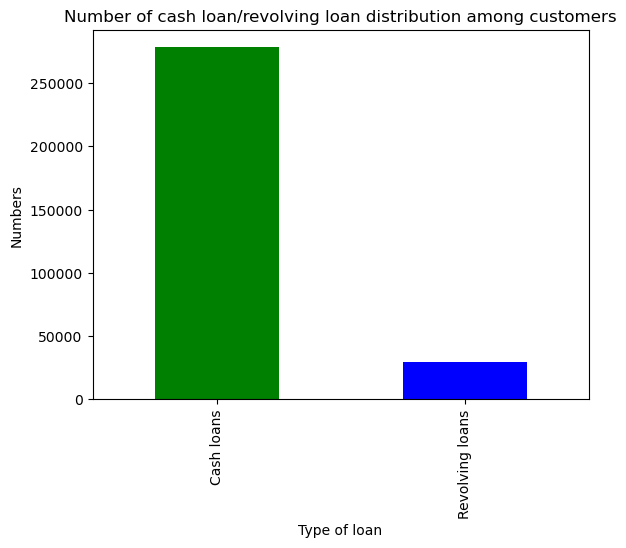

In [63]:
#Checking the values corresponding to cash or revolving loans of the customers
ax = df_cat_train['NAME_CONTRACT_TYPE'].value_counts().plot.bar(color=['green', 'blue'])
ax.set_title('Number of cash loan/revolving loan distribution among customers')
ax.set_xlabel('Type of loan')
ax.set_ylabel('Numbers')
plt.show()

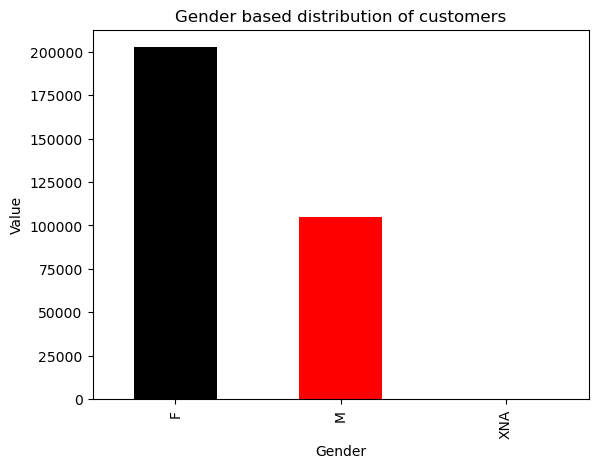

In [61]:
#Checking the values corresponding to gender of the customers
bx = df_cat_train['CODE_GENDER'].value_counts().plot.bar(color=['black', 'red', 'green', 'blue', 'cyan'])
bx.set_title('Gender based distribution of customers')
bx.set_xlabel('Gender')
bx.set_ylabel('Value')
plt.show()

Text(0.5, 0, 'target 0')

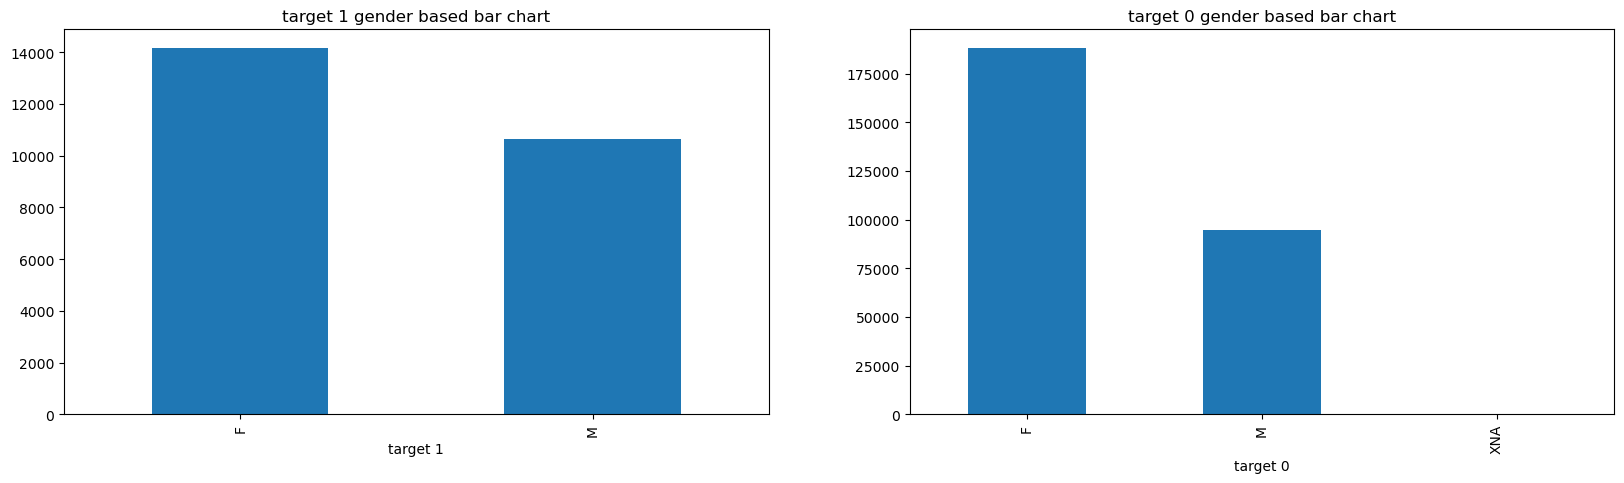

In [28]:
# Gender based target distribution
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
new_df_train.loc[new_df_train["TARGET"]==1, "CODE_GENDER"].reset_index().groupby("CODE_GENDER").size().plot(kind="bar", ax=ax1)
new_df_train.loc[new_df_train["TARGET"]==0, "CODE_GENDER"].reset_index().groupby("CODE_GENDER").size().plot(kind="bar", ax=ax2)
ax1.set_title('target 1 gender based bar chart')
ax2.set_title('target 0 gender based bar chart')
ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

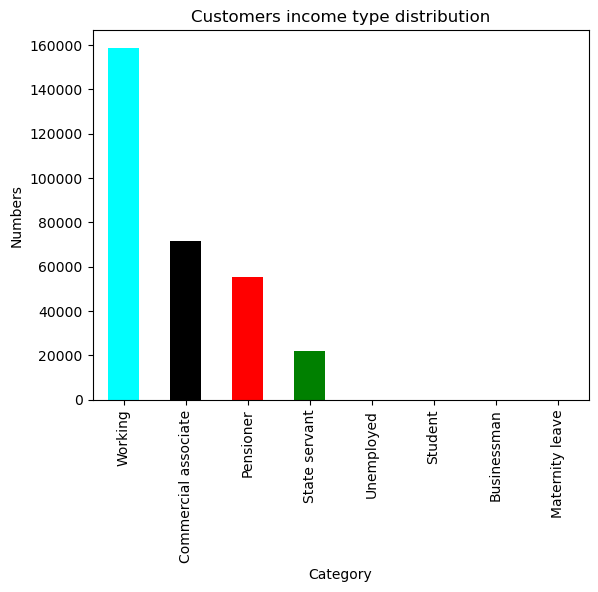

In [64]:
#Checking the distribution based on income type of the customers
cx = df_cat_train['NAME_INCOME_TYPE'].value_counts().plot.bar(color=['cyan','black', 'red', 'green', 'blue','orange','grey','yellow'])
cx.set_title('Customers income type distribution')
cx.set_xlabel('Category')
cx.set_ylabel('Numbers')
plt.show()

Text(0.5, 0, 'target 0')

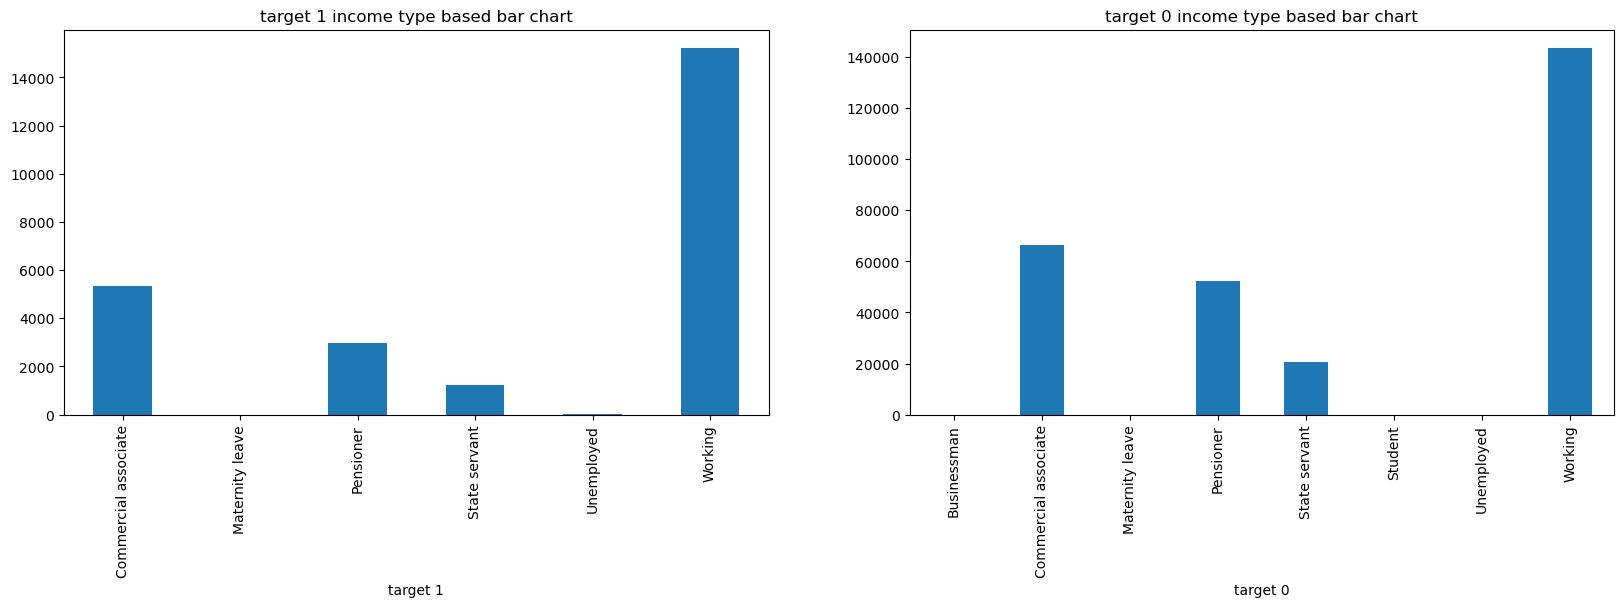

In [30]:
# Target based customer income source distribution
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
new_df_train.loc[new_df_train["TARGET"]==1, "NAME_INCOME_TYPE"].reset_index().groupby("NAME_INCOME_TYPE").size().plot(kind="bar", ax=ax1)
new_df_train.loc[new_df_train["TARGET"]==0, "NAME_INCOME_TYPE"].reset_index().groupby("NAME_INCOME_TYPE").size().plot(kind="bar", ax=ax2)
ax1.set_title('target 1 income type based bar chart')
ax2.set_title('target 0 income type based bar chart')
ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

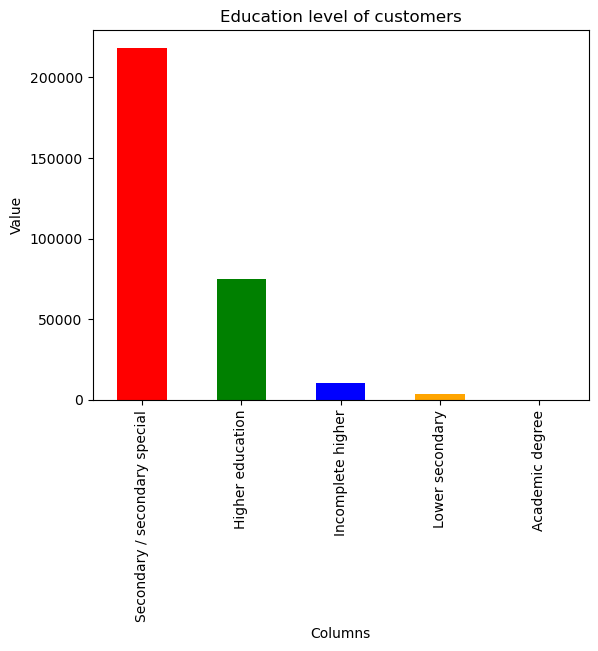

In [65]:
#Checking the distribution based on Education type of the customers
dx = df_cat_train['NAME_EDUCATION_TYPE'].value_counts().plot.bar(color=['red', 'green', 'blue','orange','grey'])
dx.set_title('Education level of customers')
dx.set_xlabel('Columns')
dx.set_ylabel('Value')
plt.show()

Text(0.5, 0, 'target 0')

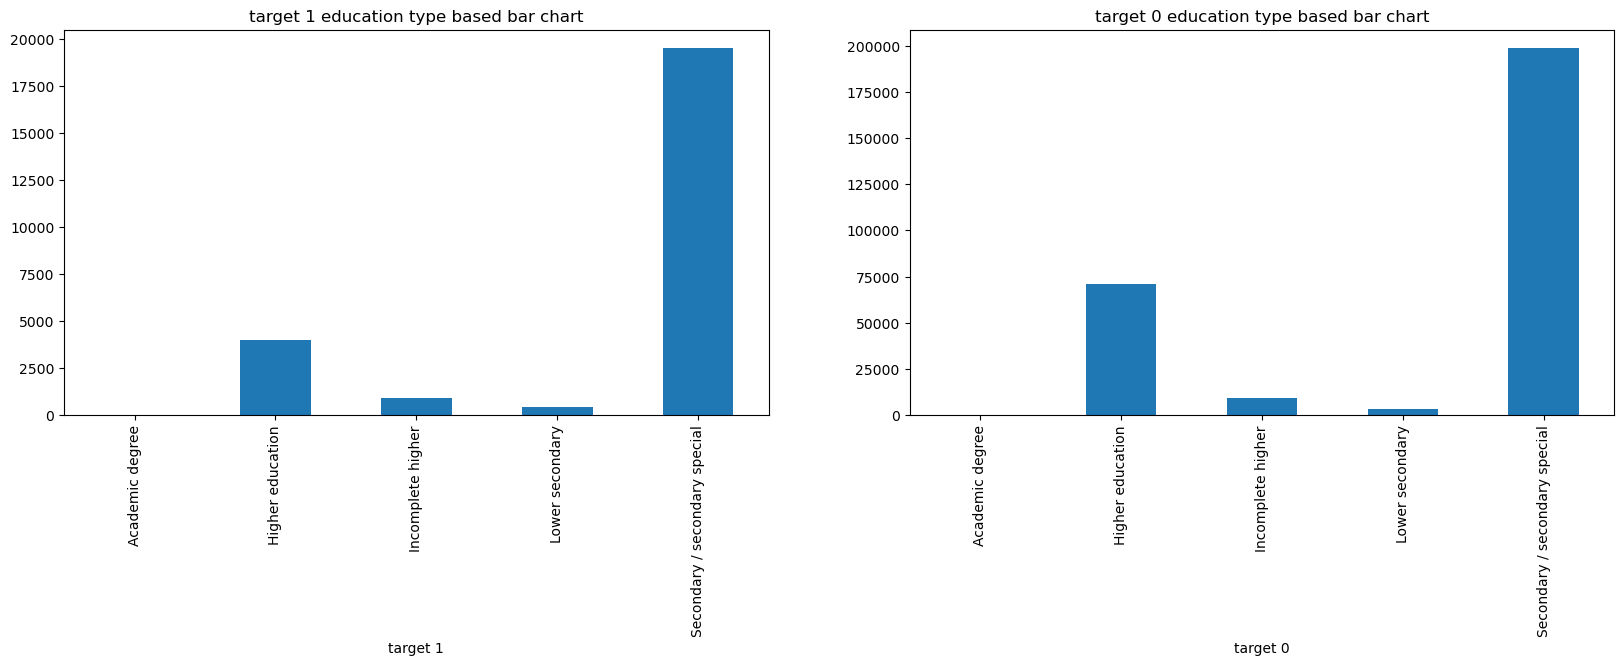

In [33]:
# Target based customer education source distribution
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5))
new_df_train.loc[new_df_train["TARGET"]==1, "NAME_EDUCATION_TYPE"].reset_index().groupby("NAME_EDUCATION_TYPE").size().plot(kind="bar", ax=ax1)
new_df_train.loc[new_df_train["TARGET"]==0, "NAME_EDUCATION_TYPE"].reset_index().groupby("NAME_EDUCATION_TYPE").size().plot(kind="bar", ax=ax2)
ax1.set_title('target 1 education type based bar chart')
ax2.set_title('target 0 education type based bar chart')
ax1.set_xlabel("target 1")
ax2.set_xlabel("target 0")

In [34]:
df_cat_train['ORGANIZATION_TYPE'].replace(['Business Entity Type 3', 'Business Entity Type 2',
                                     'Business Entity Type 1'], ['Business','Business','Business'], inplace=True)

In [35]:
df_cat_train['ORGANIZATION_TYPE'].replace(['Industry: type 9', 'Industry: type 3',
                                     'Industry: type 11','Industry: type 7','Industry: type 1',
                                     'Industry: type 4','Industry: type 2','Industry: type 12',
                                    'Industry: type 6','Industry: type 10','Industry: type 13','Industry: type 8','Industry: type 5'],
                                    ['Industry','Industry','Industry','Industry','Industry','Industry','Industry',
                                     'Industry','Industry','Industry','Industry','Industry','Industry'], inplace=True)
                                                   

In [37]:
df_cat_train['ORGANIZATION_TYPE'].replace(['Trade: type 5', 'Trade: type 4','Trade: type 1','Trade: type 6',
                                     'Trade: type 2','Trade: type 3','Trade: type 7'
                        ], ['Trade','Trade','Trade','Trade','Trade','Trade','Trade'], inplace=True)

In [38]:
df_cat_train['ORGANIZATION_TYPE'].replace(['Transport: type 4', 'Transport: type 2',
                                     'Transport: type 1', 'Transport: type 3'], ['Transport','Transport','Transport','Transport'], inplace=True)

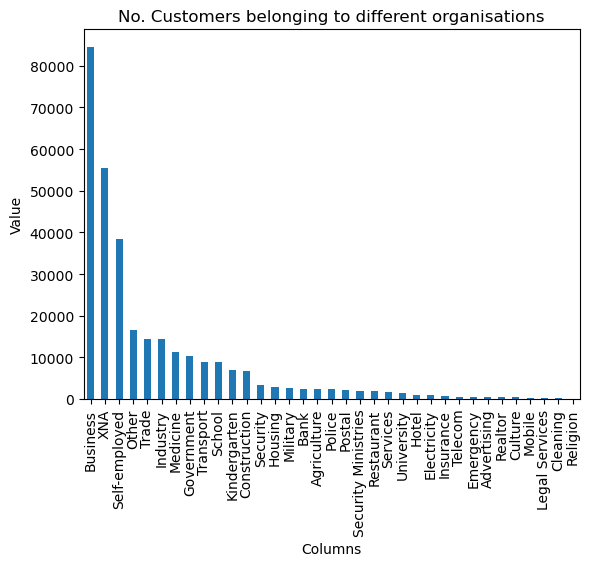

In [39]:
#Checking the distribution based on income type of the customers
dx = df_cat_train['ORGANIZATION_TYPE'].value_counts().plot(kind='bar')
dx.set_title('No. Customers belonging to different organisations')
dx.set_xlabel('Columns')
dx.set_ylabel('Value')
plt.show()

## Numerical Columns

In [70]:
#selecting numerical columns
df_num = new_df_train.select_dtypes(include=['int64','float64'])

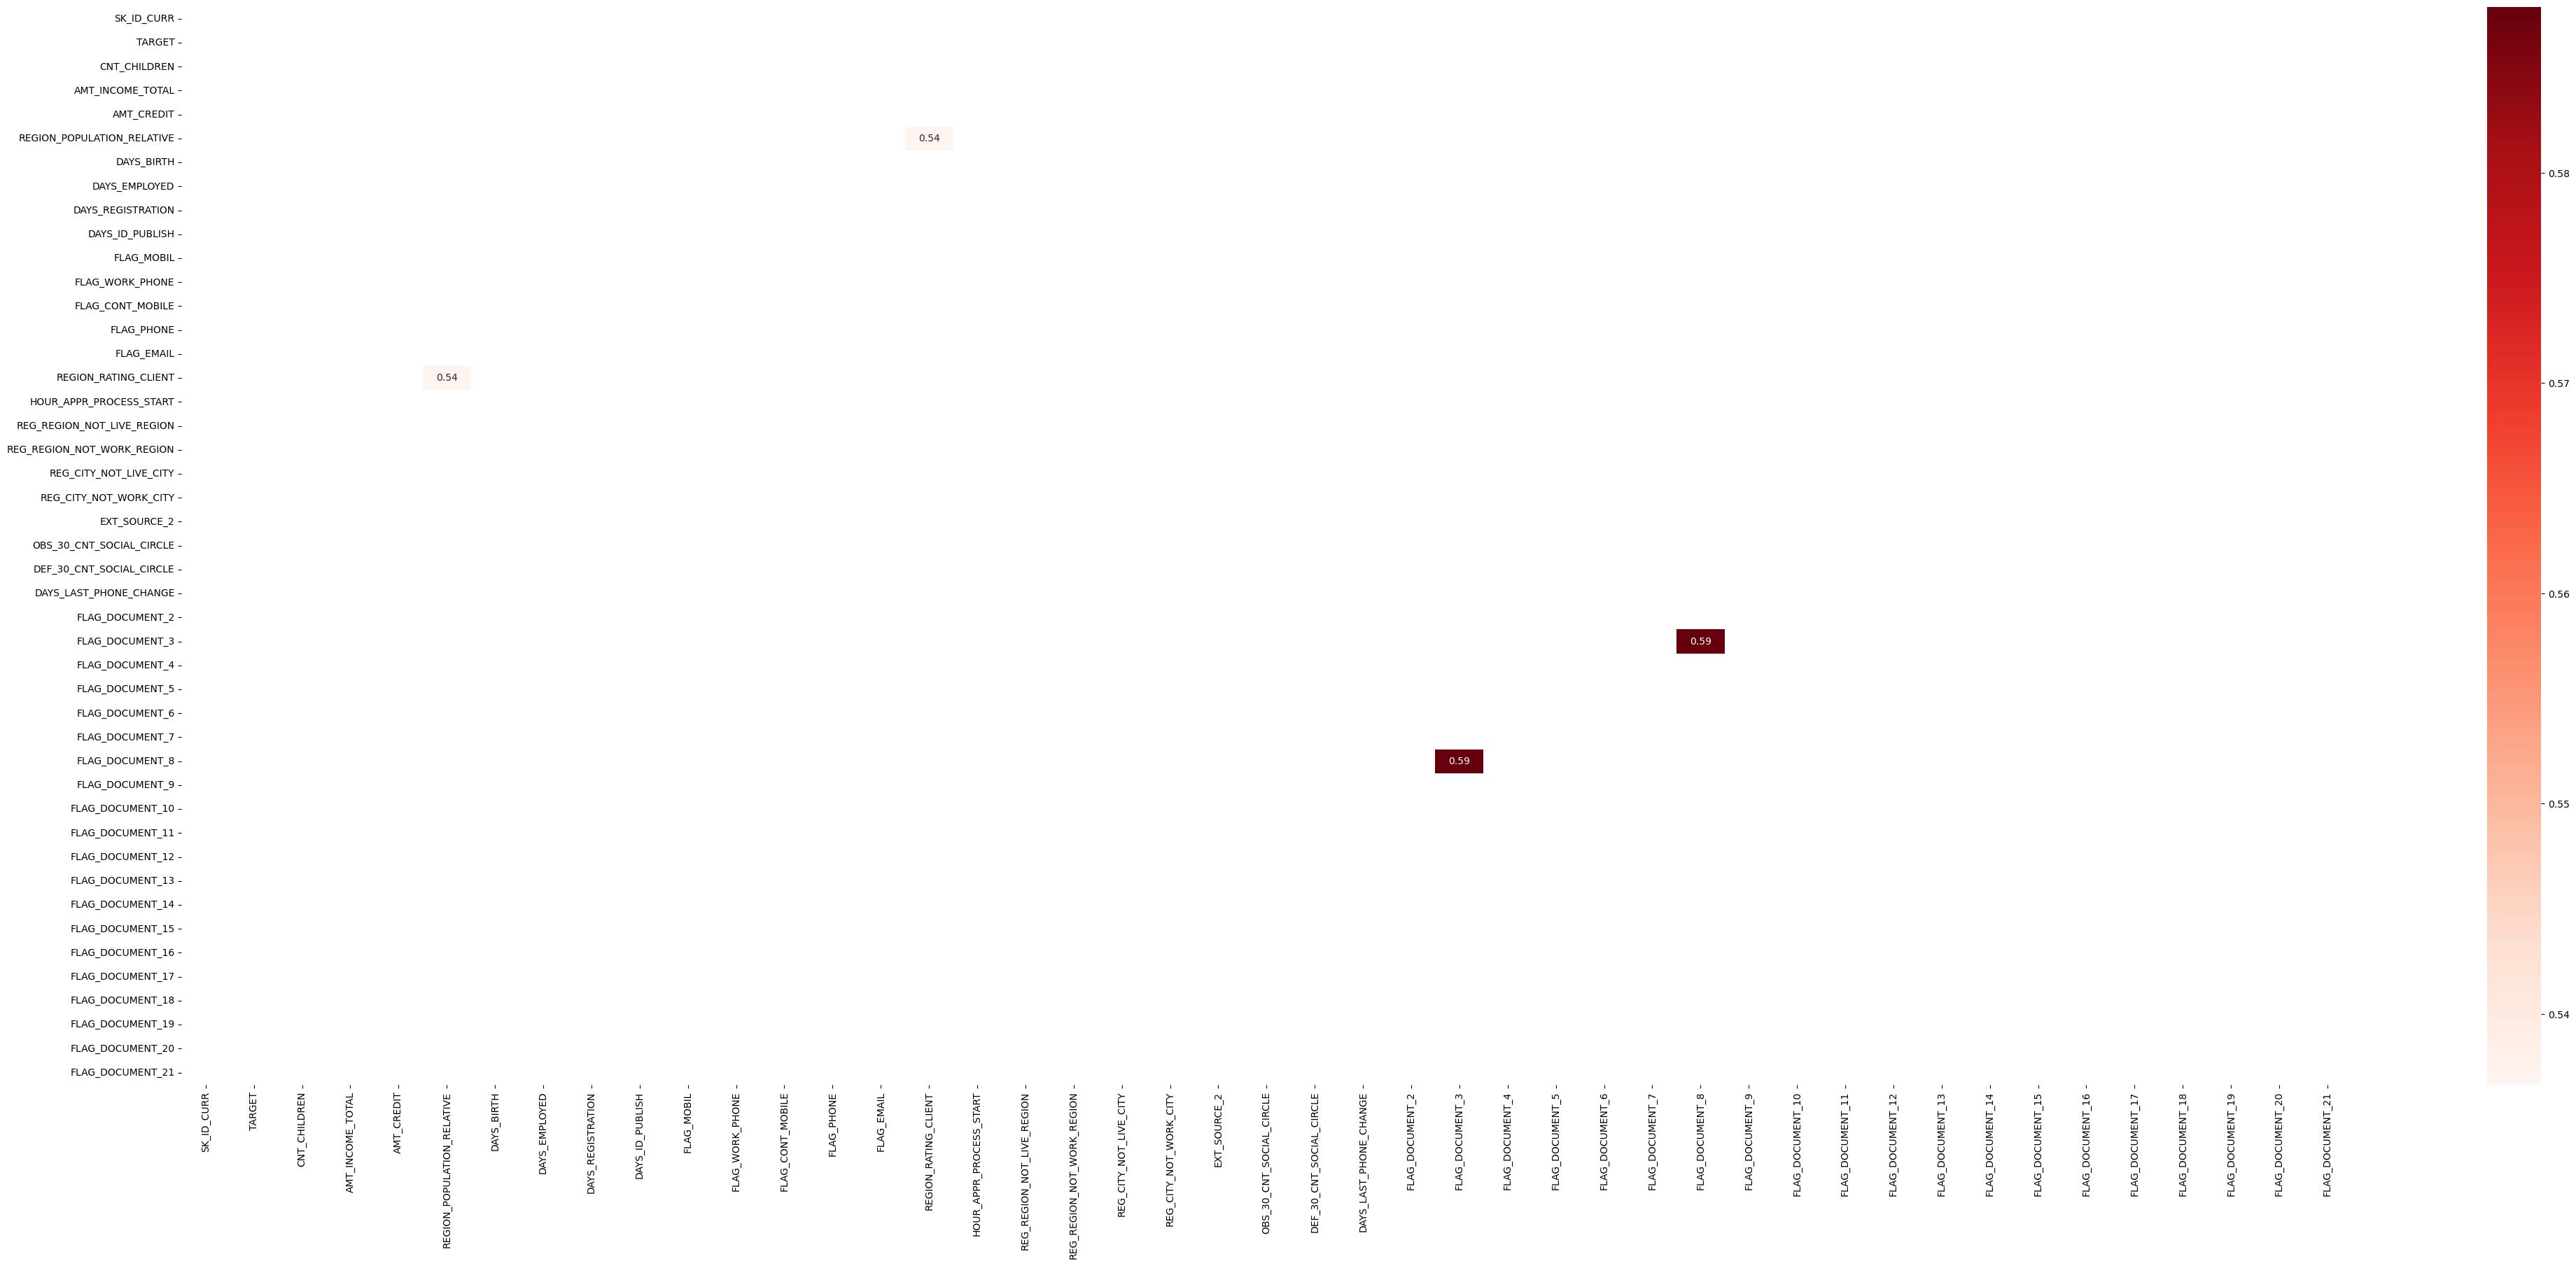

In [71]:
#calculating correlation between different columns depending on the certain conditions
dfCorr = df_num.corr().abs()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
plt.figure(figsize=(50,20))
sns.heatmap(filteredDf, annot=True, cmap="Reds")
plt.show()

In [72]:
#defining a threshold for columns
upper = dfCorr.where(np.triu(np.ones(dfCorr.shape), k=1).astype(np.bool))

In [73]:
# selecting column based on the threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.75)]

In [74]:
#dropping column bsed on the threshold
new_df_train.drop(to_drop, axis=1, inplace=True)

In [75]:
#checking the outmiers in numerical columns
df_num.describe(include = 'all')

SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  252136.000000  252136.000000  252136.000000      2.521360e+05   
mean   278115.290165       0.086596       0.498513      1.754507e+05   
std    102815.325816       0.281243       0.763162      1.134680e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189035.750000       0.000000       0.000000      1.125000e+05   
50%    278064.500000       0.000000       0.000000      1.575000e+05   
75%    367165.250000       0.000000       1.000000      2.115000e+05   
max    456255.000000       1.000000      19.000000      1.800009e+07   

         AMT_CREDIT  REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  \
count  2.521360e+05               252136.000000  252136.000000  252136.000000   
mean   6.113987e+05                    0.020894      39.963179       6.037024   
std    4.065280e+05                    0.013874      10.033192       6.416087   
min    4.500000e+04                    0.000290      20.000000       0.000000   
25%    2.779695e+05                    0.010006      32.000000       2.000000   
50%    5.212800e+05                    0.018850      39.000000       4.000000   
75%    8.292240e+05                    0.028663      48.000000       8.000000   
max    4.050000e+06                    0.072508      69.000000      49.000000   

       DAYS_REGISTRATION  DAYS_ID_PUBLISH     FLAG_MOBIL  FLAG_WORK_PHONE  \
count      252136.000000    252136.000000  252136.000000    252136.000000   
mean           12.208280         7.184012       0.999996         0.243151   
std             8.905543         4.149693       0.001992         0.428986   
min             0.000000         0.000000       0.000000         0.000000   
25%             5.000000         4.000000       1.000000         0.000000   
50%            11.000000         7.000000       1.000000         0.000000   
75%            19.000000        11.000000       1.000000         0.000000   
max            62.000000        19.000000       1.000000         1.000000   

       FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  REGION_RATING_CLIENT  \
count     252136.000000  252136.000000  252136.000000         252136.000000   
mean           0.997874       0.277683       0.063501              2.044615   
std            0.046058       0.447857       0.243863              0.512385   
min            0.000000       0.000000       0.000000              1.000000   
25%            1.000000       0.000000       0.000000              2.000000   
50%            1.000000       0.000000       0.000000              2.000000   
75%            1.000000       1.000000       0.000000              2.000000   
max            1.000000       1.000000       1.000000              3.000000   

       HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
count            252136.000000               252136.000000   
mean                 12.203295                    0.017241   
std                   3.299804                    0.130167   
min                   0.000000                    0.000000   
25%                  10.000000                    0.000000   
50%                  12.000000                    0.000000   
75%                  15.000000                    0.000000   
max                  23.000000                    1.000000   

       REG_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
count               252136.000000           252136.000000   
mean                     0.061919                0.089769   
std                      0.241009                0.285851   
min                      0.000000                0.000000   
25%                      0.000000                0.000000   
50%                      0.000000                0.000000   
75%                      0.000000                0.000000   
max                      1.000000                1.000000   

       REG_CITY_NOT_WORK_CITY  EXT_SOURCE_2  OBS_30_CNT_SOCIAL_CIRCLE  \
count           252136.000000  2.521360e+05

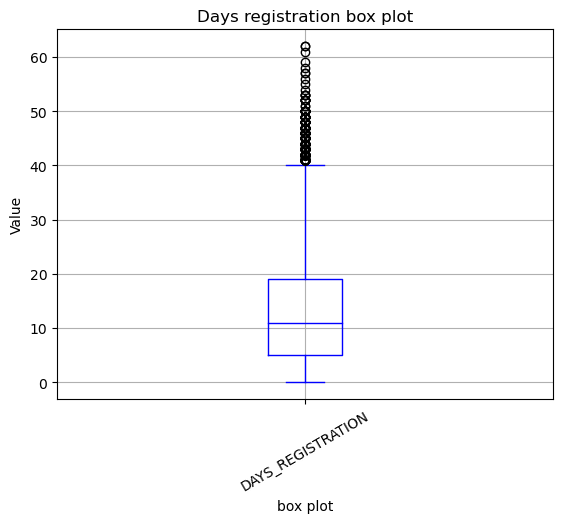

In [76]:
#box plot of the column 'Days registration' showing the different quertile ranges and outliers
ex = df_num.boxplot(column=['DAYS_REGISTRATION'], grid='true', color='blue',fontsize=10, rot=30)
ex.set_title('Days registration box plot')
ex.set_xlabel('box plot')
ex.set_ylabel('Value')
plt.show()

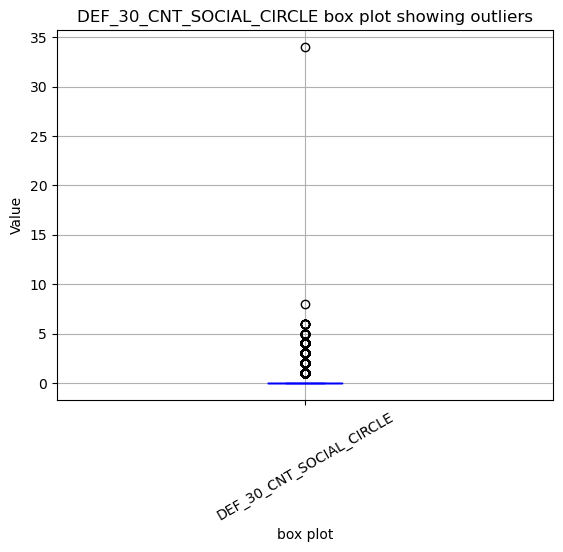

In [77]:
#box plot of the column 'DEF_30_CNT_SOCIAL_CIRCLE' showing the different quertile ranges and outliers
fx = df_num.boxplot(column=['DEF_30_CNT_SOCIAL_CIRCLE'], grid='true', color='blue',fontsize=10, rot=30)
fx.set_title('DEF_30_CNT_SOCIAL_CIRCLE box plot showing outliers')
fx.set_xlabel('box plot')
fx.set_ylabel('Value')
plt.show()

In [78]:
#removing the outlier
new_df_train.drop(new_df_train.index[new_df_train['DEF_30_CNT_SOCIAL_CIRCLE'] == 348.000000], inplace = True)

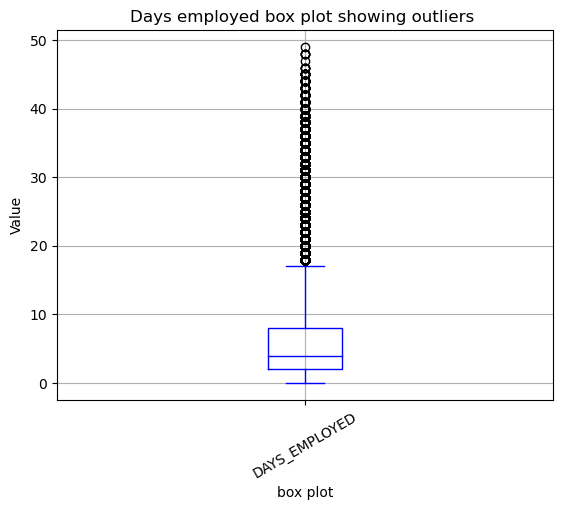

In [79]:
#box plot of the column 'Days employed' showing the different quertile ranges and outliers
gx = df_num.boxplot(column=['DAYS_EMPLOYED'], grid='true', color='blue',fontsize=10, rot=30)
gx.set_title('Days employed box plot showing outliers ')
gx.set_xlabel('box plot')
gx.set_ylabel('Value')
plt.show()

In [80]:
#removing the outlier
new_df_train.drop(new_df_train.index[new_df_train['DAYS_EMPLOYED'] == 1000.000000], inplace = True)

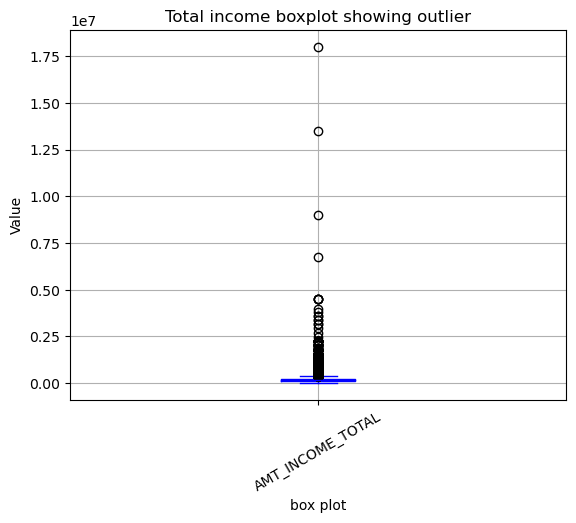

In [81]:
#box plot of the column 'Amt_income_total' showing the different quertile ranges and outliers
hx = df_num.boxplot(column=['AMT_INCOME_TOTAL'], grid='true', color='blue',fontsize=10, rot=30)
hx.set_title('Total income boxplot showing outlier')
hx.set_xlabel('box plot')
hx.set_ylabel('Value')
plt.show()

In [82]:
# removing outlier
new_df_train.drop(new_df_train.index[new_df_train['AMT_INCOME_TOTAL'] == 1.170000e+08 ], inplace = True)

## Label encoder

Label Encoding is a technique that is used to convert categorical columns into numerical ones so that they can be fitted by machine learning models which only take numerical data. It is an important pre-processing step in a machine-learning project

In [84]:
l = LabelEncoder()
for p in new_df_train.describe(include='object').columns:
    new_df_train[p]=l.fit_transform(new_df_train[p])
new_df_train

ValueError: No objects to concatenate

In [85]:
new_df_train.head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  \
0      100002       1                   0            1             0   
1      100003       0                   0            0             0   
2      100004       0                   1            1             1   
3      100006       0                   0            0             0   
4      100007       0                   0            1             0   

   FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                1             0          202500.0    406597.5   
1                0             0          270000.0   1293502.5   
2                1             0           67500.0    135000.0   
3                1             0          135000.0    312682.5   
4                1             0          121500.0    513000.0   

   NAME_TYPE_SUITE  NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                6                 6                    4                   3   
1                1                 4                    1                   1   
2                6                 6                    4                   3   
3                6                 6                    4                   0   
4                6                 6                    4                   3   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  1                    0.018801          25              1   
1                  1                    0.003541          45              3   
2                  1                    0.010032          52              0   
3                  1                    0.008019          52              8   
4                  1                    0.028663          54              8   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_WORK_PHONE  \
0                  9                5           1                0   
1                  3                0           1                0   
2                 11                6           1                1   
3                 26                6           1                0   
4                 11                9           1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0                 1           1           0                     2   
1                 1           1           0                     1   
2                 1           1           0                     2   
3                 1           0           0                     2   
4                 1           0           0                     2   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                           6                       10   
1                           1                       11   
2                           1                        9   
3                           6                       17   
4                           4                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE  \
0                       0                       0                  5   
1                       0                       0                 39   
2                       0                       0                 11   
3                       0                       0                  5   
4                       0                       1                 37   

   EXT_SOURCE_2  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0      0.262949                       2.0                       2.0   
1      0.622246                       1.0                       0.0   
2      0.5559

In [86]:
new_df_train.shape

(252136, 56)

In [87]:
#defining x and y variables for model building and dropping target and Id columns
x=new_df_train.drop(['TARGET','SK_ID_CURR'],axis=1)
print(x)
y= new_df_train['TARGET']
print(y)

        NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0                        0            1             0                1   
1                        0            0             0                0   
2                        1            1             1                1   
3                        0            0             0                1   
4                        0            1             0                1   
...                    ...          ...           ...              ...   
307504                   0            0             0                1   
307506                   0            1             0                0   
307508                   0            0             0                1   
307509                   0            0             0                1   
307510                   0            0             0                0   

        CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  NAME_TYPE_SUITE  \
0                  0          202500.0  

## Handling imbalanced data with SMOTE

Synthetic Minority Oversampling Technique (SMOTE). SMOTE is specifically designed to tackle imbalanced datasets by generating synthetic samples for the minority class.

In [90]:
#calling SMOTE function
smote = SMOTE()

In [91]:
#fitting x and y in smote function
x_smote, y_smote = smote.fit_resample(x, y)

## Standardization

In [92]:
#StandardScaler performs the task of Standardization.
#The idea behind StandardScaler is that it will transform your data such that its distribution will have a 
#mean value 0 and standard deviation of 1
sc = StandardScaler() 
x_smote = sc.fit_transform(x_smote)

## External test set

In [93]:
#loading external test set 
test_new = pd.read_csv('y_new.csv')

In [94]:
test_new.head()

SK_ID_CURR  NAME_CONTRACT_TYPE  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      100001                   0            0             0                1   
1      100005                   0            1             0                1   
2      100013                   0            1             1                1   
3      100028                   0            0             0                1   
4      100038                   0            1             1                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  NAME_TYPE_SUITE  \
0             0          135000.0    568800.0                6   
1             0           99000.0    222768.0                6   
2             0          202500.0    663264.0                7   
3             2          315000.0   1575000.0                6   
4             1          180000.0    625500.0                6   

   NAME_INCOME_TYPE  NAME_EDUCATION_TYPE  NAME_FAMILY_STATUS  \
0                 6                    1                   1   
1                 6                    4                   1   
2                 6                    1                   1   
3                 6                    4                   1   
4                 6                    4                   1   

   NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
0                  1                    0.018850          52              6   
1                  1                    0.035792          49             12   
2                  1                    0.019101          54             12   
3                  1                    0.026392          38              5   
4                  1                    0.010032          35              6   

   DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_WORK_PHONE  \
0                 14                2           1                0   
1                 24                4           1                0   
2                  5                9           1                0   
3                  5               11           1                0   
4                 10               11           1                1   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  REGION_RATING_CLIENT  \
0                 1           0           1                     2   
1                 1           0           0                     2   
2                 1           0           0                     2   
3                 1           1           0                     2   
4                 1           0           0                     2   

   WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  \
0                           5                       18   
1                           0                        9   
2                           1                       14   
3                           6                       11   
4                           0                        5   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  ORGANIZATION_TYPE  \
0                       0                       0                 28   
1                       0                       0                 42   
2                       0                       0                 54   
3                       0                       0                  5   
4                       0                       1                  5   

   EXT_SOURCE_2  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  \
0      0.789654                       0.0                       0.0   
1      0.291656                       0.0                       0.0   
2      0.699787                       0.0                    

In [95]:
#dropping ID column
test_new_y = test_new.drop(['SK_ID_CURR'],axis=1)

In [67]:
#standarising external test set
sc = StandardScaler()#fit 
test_new_y = sc.fit_transform(test_new_y)

## Train test Split

In [96]:
# split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size = 0.3, random_state = 10)

# Model Building

## Logistic regression

Logistic regression is a supervised machine learning algorithm mainly used for classification tasks where the goal is to predict the probability that an instance of belonging to a given class. It is used for classification algorithms its name is logistic regression. it’s referred to as regression because it takes the output of the linear regression function as input and uses a sigmoid function to estimate the probability for the given class.

In [97]:
# fit a model
classifier =  LogisticRegression(max_iter=3000)
classifier.fit(x_train, y_train)
# predict probabilities
y_pred_lg = classifier.predict(x_test)
lg_probs = classifier.predict_proba(x_test)
# keep probabilities for the positive outcome only
lg_probs = lg_probs[:, 1]

#calculating accuracy,recall,precision and roc score
lg_accuracy=accuracy_score(y_test, y_pred_lg)
lg_recall=recall_score(y_test,y_pred_lg)
lg_precision=precision_score(y_test,y_pred_lg)
lg_rocauc=roc_auc_score(y_test,y_pred_lg)

print('{:.4f}'.format(lg_accuracy), '- Lg Accuracy')
print('{:.4f}'.format(lg_recall), '- Lg Recall')
print('{:.4f}'.format(lg_precision), '- Lg Precision')
print('{:.4f}'.format(lg_rocauc), '- Lg ROC AUC')

0.8147 - Lg Accuracy
0.8205 - Lg Recall
0.8119 - Lg Precision
0.8146 - Lg ROC AUC


## ROC Curve

The Reciever operating characteristic curve(ROC) plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

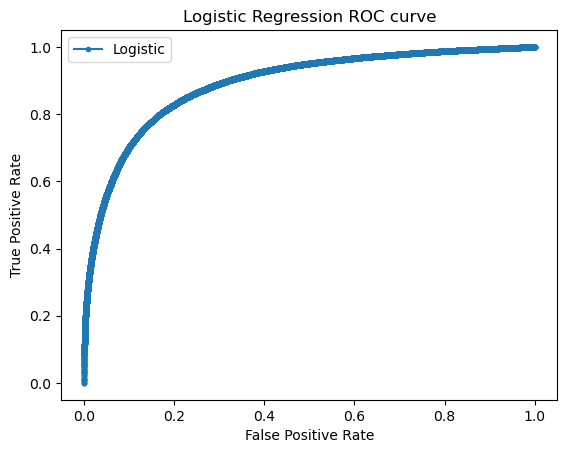

In [101]:
# calculate roc curves
lg_fpr, lg_tpr, _ = roc_curve(y_test, lg_probs)
# plot the roc curve for the model
plt.plot(lg_fpr, lg_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Logistic Regression ROC curve')

# show the plot
plt.show()

## Precision-recall Curve

Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.
ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.


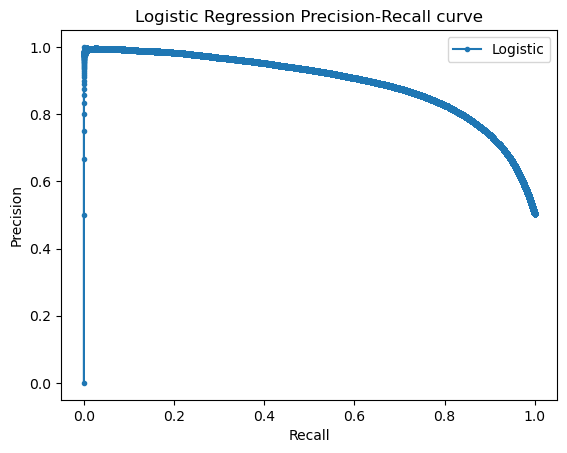

In [103]:
# calculate precision and recall for each threshold
lg_precision, lg_recall, _ = precision_recall_curve(y_test, lg_probs)
plt.plot(lg_recall, lg_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Logistic Regression Precision-Recall curve')
# show the plot
plt.show()

## external dataset prediction using Logistic regression

In [104]:
predictions = classifier.predict_proba(test_new_y)
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(test_new_y), columns = ['predicted_TARGET'])
df=pd.concat([df_prediction_prob, df_prediction_target], axis=1)
df.sort_values(by=['prob_0'],  ascending=[False],inplace=True)
df

prob_0  prob_1  predicted_TARGET
0         1.0     0.0                 0
30464     1.0     0.0                 0
30467     1.0     0.0                 0
30468     1.0     0.0                 0
30469     1.0     0.0                 0
...       ...     ...               ...
6306      0.0     1.0                 1
34617     0.0     1.0                 1
29858     0.0     1.0                 1
6303      0.0     1.0                 1
17302     0.0     1.0                 1

[48741 rows x 3 columns]

## Random Forest classifier

Random Forest is one of the most popular and commonly used algorithms by Data Scientists. Random forest is a Supervised Machine Learning Algorithm that is used widely in Classification and Regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.

In [105]:
rf= RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict(x_test)
rf_probs = rf.predict_proba(x_test)
rf_probs = rf_probs[:, 1]

#calculating accuracy,recall,precision and roc score
rf_accuracy=accuracy_score(y_test, y_pred_rf)
rf_recall=recall_score(y_test,y_pred_rf)
rf_precision=precision_score(y_test,y_pred_rf)
rf_rocauc=roc_auc_score(y_test,y_pred_rf)

print('{:.4f}'.format(rf_accuracy), '- RF Accuracy')
print('{:.4f}'.format(rf_recall), '- RF Recall')
print('{:.4f}'.format(rf_precision), '- RF Precision')
print('{:.4f}'.format(rf_rocauc), '- RF ROC AUC')

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    5.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.6s finished


0.9243 - RF Accuracy
0.8868 - RF Recall
0.9590 - RF Precision
0.9244 - RF ROC AUC


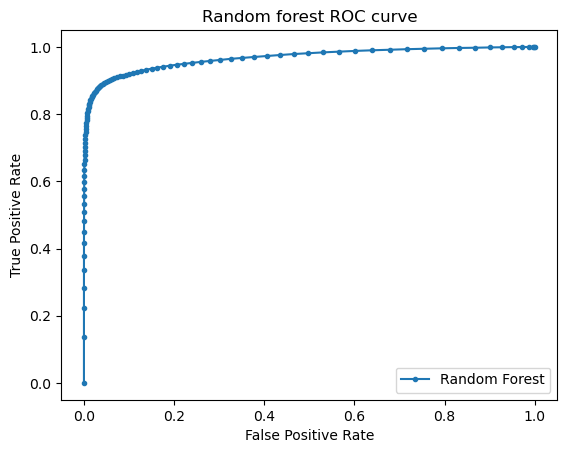

In [106]:
# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
# plot the roc curve for the model
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random forest ROC curve')

# show the plot
plt.show()

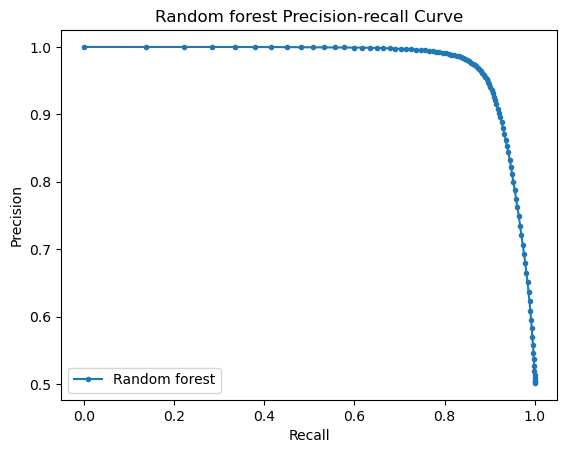

In [107]:
# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)
plt.plot(rf_recall, rf_precision, marker='.', label='Random forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Random forest Precision-recall Curve')
# show the plot
plt.show()

In [108]:
predictions_rf = rf.predict_proba(test_new_y)
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(test_new_y), columns = ['predicted_TARGET'])
df_rf = pd.concat([df_prediction_prob, df_prediction_target], axis=1)
df_rf.sort_values(by=['prob_0'],  ascending=[False],inplace=True)
df_rf

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


prob_0  prob_1  predicted_TARGET
0         1.0     0.0                 0
30464     1.0     0.0                 0
30467     1.0     0.0                 0
30468     1.0     0.0                 0
30469     1.0     0.0                 0
...       ...     ...               ...
6306      0.0     1.0                 1
34617     0.0     1.0                 1
29858     0.0     1.0                 1
6303      0.0     1.0                 1
17302     0.0     1.0                 1

[48741 rows x 3 columns]

## LightGBM

LightGBM is a gradient boosting framework that uses tree based learning algorithms.
Gradient Boosting is a powerful boosting algorithm that combines several weak learners into strong learners, in which each new model is trained to minimize the loss function such as mean squared error or cross-entropy of the previous model using gradient descent.It is designed to be distributed and efficient with the following advantages:

1.Faster training speed and higher efficiency.

2.Lower memory usage.

3.Better accuracy.

4.Support of parallel, distributed, and GPU learning.

5.Capable of handling large-scale data.

In [109]:
import lightgbm as lgb
clf = lgb.LGBMClassifier()
clf.fit(x_train, y_train)

y_pred_lgb = clf.predict(x_test)
lgb_probs = clf.predict_proba(x_test)
lgb_probs = lgb_probs[:, 1]

#calculating accuracy,recall,precision and roc score
lgb_accuracy=accuracy_score(y_test, y_pred_lgb)
lgb_recall=recall_score(y_test,y_pred_lgb)
lgb_precision=precision_score(y_test,y_pred_lgb)
lgb_rocauc=roc_auc_score(y_test,y_pred_lgb)

print('{:.4f}'.format(lgb_accuracy), '- LGB Accuracy')
print('{:.4f}'.format(lgb_recall), '- LGB Recall')
print('{:.4f}'.format(lgb_precision), '- LGB Precision')
print('{:.4f}'.format(lgb_rocauc), '- LGB ROC AUC')


0.9381 - LGB Accuracy
0.8902 - LGB Recall
0.9848 - LGB Precision
0.9382 - LGB ROC AUC


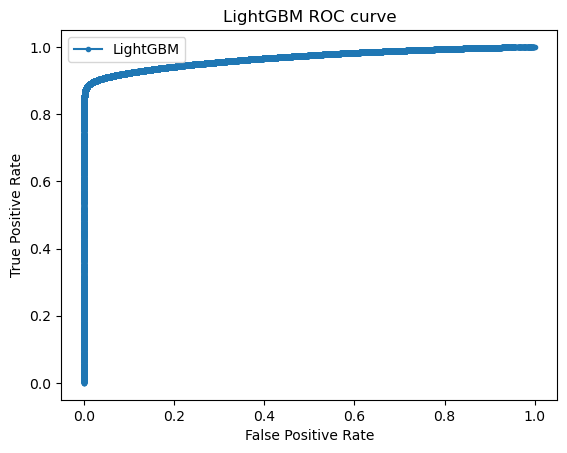

In [110]:
# calculate roc curves
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_probs)
# plot the roc curve for the model
plt.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('LightGBM ROC curve')
# show the plot
plt.show()

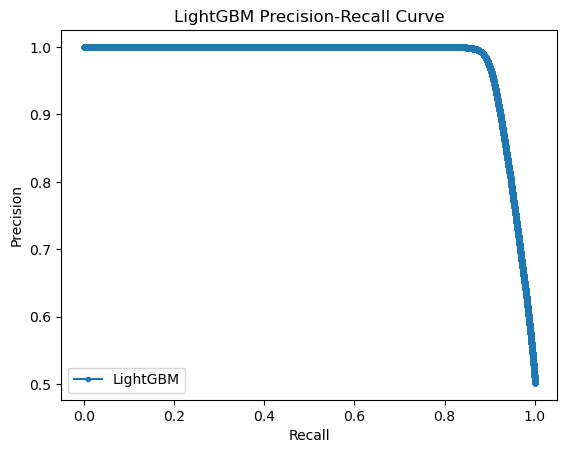

In [111]:
# calculate precision and recall for each threshold
lgb_precision, lgb_recall, _ = precision_recall_curve(y_test, lgb_probs)
plt.plot(lgb_recall, lgb_precision, marker='.', label='LightGBM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('LightGBM Precision-Recall Curve')
# show the plot
plt.show()

In [112]:
predictions_rf = clf.predict_proba(test_new_y)
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(test_new_y), columns = ['predicted_TARGET'])
df_clf = pd.concat([df_prediction_prob, df_prediction_target], axis=1)
df_clf.sort_values(by=['prob_0'],  ascending=[False],inplace=True)
df_clf

prob_0  prob_1  predicted_TARGET
0         1.0     0.0                 0
30464     1.0     0.0                 0
30467     1.0     0.0                 0
30468     1.0     0.0                 0
30469     1.0     0.0                 0
...       ...     ...               ...
6306      0.0     1.0                 1
34617     0.0     1.0                 1
29858     0.0     1.0                 1
6303      0.0     1.0                 1
17302     0.0     1.0                 1

[48741 rows x 3 columns]

## Models ROC curve combined

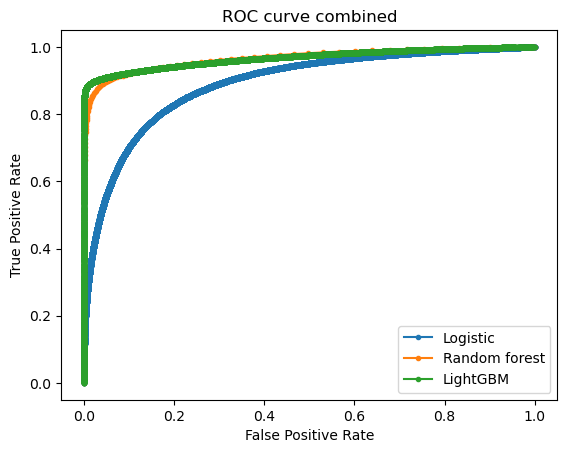

In [113]:
plt.plot(lg_fpr, lg_tpr, marker='.', label='Logistic')
plt.plot(rf_fpr, rf_tpr, marker='.', label='Random forest')
plt.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve combined')
# show the legend
plt.legend()
# show the plot
plt.show()

## Models Precision-Recall curve combined

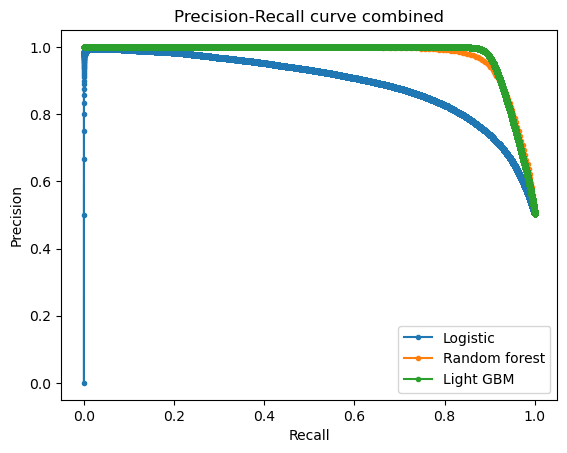

In [114]:
plt.plot(lg_recall, lg_precision, marker='.', label='Logistic')

plt.plot(rf_recall, rf_precision, marker='.', label='Random forest')

plt.plot(lgb_recall, lgb_precision, marker='.', label='Light GBM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve combined')
# show the legend
plt.legend()
# show the plot
plt.show()


# Hyperparameters tuning

Hyperparameter tuning is basically referred to as tweaking the parameters of the model.Some set of parameters that are used to control the behaviour of the model/algorithm and adjustable in order to obtain an improvised model with optimal performance is so-called Hyperparameters.

The best model algorithm(s) will sparkle if your best choice of Hyper-parameters



## Logistic regression

In [115]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
#solvers = ['lbfgs']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,C=c_values,penalty= penalty)
cv = StratifiedKFold(n_splits=4)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                           scoring='average_precision', verbose=1)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best: 0.894581 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}


In [116]:
model_new_lg = LogisticRegression(**grid_result.best_params_)
model_new_lg.fit(x_train, y_train)

y_pred_lg = model_new_lg.predict(x_test)
lg_probs = model_new_lg.predict_proba(x_test)
lg_probs_hyp = lg_probs[:, 1]

In [117]:
#calculating accuracy,recall,precision and roc score
lg_hyp_accuracy=accuracy_score(y_test, y_pred_lg)
lg_hyp_recall=recall_score(y_test,y_pred_lg)
lg_hyp_precision=precision_score(y_test,y_pred_lg)
lg_hyp_rocauc=roc_auc_score(y_test,y_pred_lg)

print('{:.4f}'.format(lg_hyp_accuracy), '- LG_hyp_Accuracy')
print('{:.4f}'.format(lg_hyp_recall), '- LG_hyp_Recall')
print('{:.4f}'.format(lg_hyp_precision), '- LG_hyp_Precision')
print('{:.4f}'.format(lg_hyp_rocauc), '- LG_hyp_ROC AUC')

0.8147 - LG_hyp_Accuracy
0.8205 - LG_hyp_Recall
0.8119 - LG_hyp_Precision
0.8146 - LG_hyp_ROC AUC


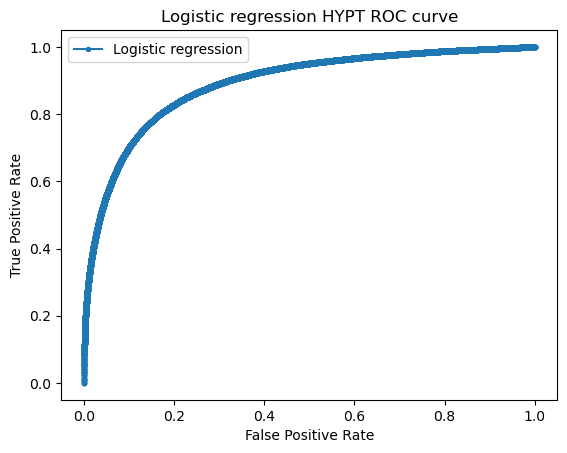

In [119]:
# calculate roc curves
lg_hyp_fpr, lg_hyp_tpr, _ = roc_curve(y_test, lg_probs_hyp)
# plot the roc curve for the model
plt.plot(lg_hyp_fpr, lg_hyp_tpr, marker='.', label='Logistic regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Logistic regression HYPT ROC curve')
# show the plot
plt.show()

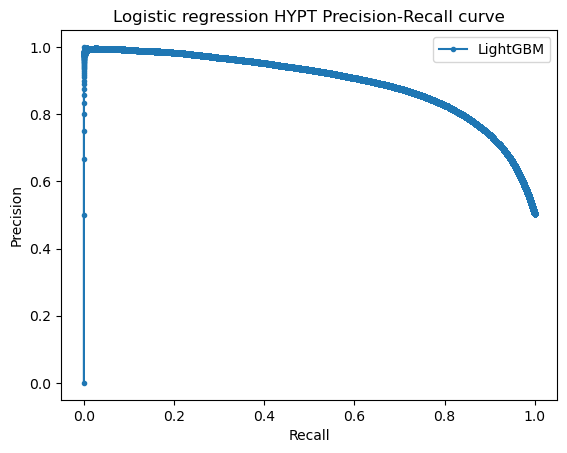

In [120]:
# calculate precision and recall for each threshold
lg_hyp_precision, lg_hyp_recall, _ = precision_recall_curve(y_test, lg_probs_hyp)
plt.plot(lg_hyp_recall, lg_hyp_precision, marker='.', label='LightGBM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Logistic regression HYPT Precision-Recall curve')
# show the plot
plt.show()

In [121]:
predictions_lg_hyp = model_new_lg.predict_proba(test_new_y)
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(test_new_y), columns = ['predicted_TARGET'])
df_lg_hyp = pd.concat([df_prediction_prob, df_prediction_target], axis=1)
df_lg_hyp.sort_values(by=['prob_0'],  ascending=[False],inplace=True)
df_lg_hyp

prob_0  prob_1  predicted_TARGET
0         1.0     0.0                 0
30464     1.0     0.0                 0
30467     1.0     0.0                 0
30468     1.0     0.0                 0
30469     1.0     0.0                 0
...       ...     ...               ...
6306      0.0     1.0                 1
34617     0.0     1.0                 1
29858     0.0     1.0                 1
6303      0.0     1.0                 1
17302     0.0     1.0                 1

[48741 rows x 3 columns]

## Random forest Classifier

In [122]:
clf=RandomForestClassifier()
param_grid = {'n_estimators': range(5,50,100),
            'max_depth' : range(1,5,1),
            'random_state': [42] ,
            'criterion':["gini"],#, "entropy"],,
            'max_features':["auto"]}#, "sqrt", "log2"] 
            
kfold = StratifiedKFold(n_splits=4)
CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv=kfold, scoring="f1", verbose=1, n_jobs=-1)
CV_clf.fit(x_train, y_train)

print("Best Params : ")
print(CV_clf.best_params_)

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best Params : 
{'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 5, 'random_state': 42}


In [123]:
clf1=RandomForestClassifier(**CV_clf.best_params_)
clf1.fit(x_train, y_train)
y_pred_rf = clf1.predict(x_test)
rf_probs = clf1.predict_proba(x_test)
rf_probs_hyp = rf_probs[:, 1]

In [124]:
#calculating accuracy,recall,precision and roc score
rf_hyp_accuracy=accuracy_score(y_test, y_pred_rf)
rf_hyp_recall=recall_score(y_test,y_pred_rf)
rf_hyp_precision=precision_score(y_test,y_pred_rf)
rf_hyp_rocauc=roc_auc_score(y_test,y_pred_rf)

print('{:.4f}'.format(rf_hyp_accuracy), '- RF_hyp Accuracy')
print('{:.4f}'.format(rf_hyp_recall), '- RF_hyp Recall')
print('{:.4f}'.format(rf_hyp_precision), '- RF_hyp Precision')
print('{:.4f}'.format(rf_hyp_rocauc), '- RF_hyp ROC AUC')

0.7686 - RF_hyp Accuracy
0.7562 - RF_hyp Recall
0.7764 - RF_hyp Precision
0.7686 - RF_hyp ROC AUC


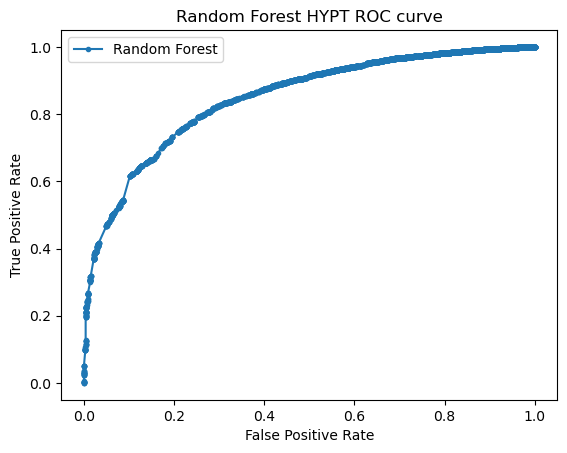

In [125]:
# calculate roc curves
rf_hyp_fpr, rf_hyp_tpr, _ = roc_curve(y_test, rf_probs_hyp)
# plot the roc curve for the model
plt.plot(rf_hyp_fpr, rf_hyp_tpr, marker='.', label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('Random Forest HYPT ROC curve')
# show the plot
plt.show()

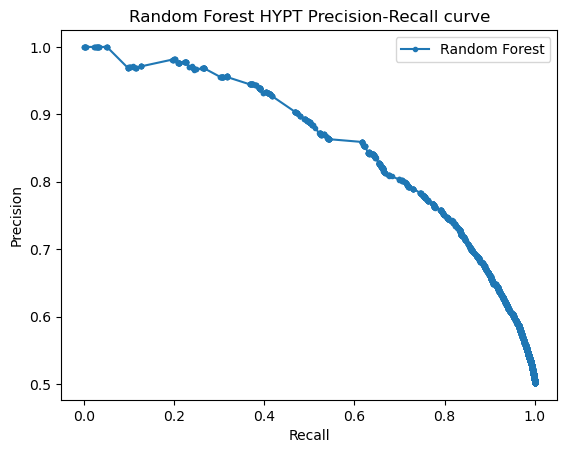

In [126]:
# calculate precision and recall for each threshold
rf_hyp_precision, rf_hyp_recall, _ = precision_recall_curve(y_test, rf_probs_hyp)
plt.plot(rf_hyp_recall, rf_hyp_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('Random Forest HYPT Precision-Recall curve')
# show the plot
plt.show()

In [127]:
predictions_rf_hyp = clf1.predict_proba(test_new_y)
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(test_new_y), columns = ['predicted_TARGET'])
df_rf_hyp = pd.concat([df_prediction_prob, df_prediction_target], axis=1)
df_rf_hyp.sort_values(by=['prob_0'],  ascending=[False],inplace=True)
df_rf_hyp

prob_0  prob_1  predicted_TARGET
0         1.0     0.0                 0
30464     1.0     0.0                 0
30467     1.0     0.0                 0
30468     1.0     0.0                 0
30469     1.0     0.0                 0
...       ...     ...               ...
6306      0.0     1.0                 1
34617     0.0     1.0                 1
29858     0.0     1.0                 1
6303      0.0     1.0                 1
17302     0.0     1.0                 1

[48741 rows x 3 columns]

## Light GBM

In [128]:
model = lgb.LGBMClassifier()
param_lgb = {'max_depth':[3,5,7],
             'reg_alpha':[0,0.5],
             'reg_lambda':[0,0.5],
             'n_estimators':range(20,51,5)}


cv = StratifiedKFold(n_splits=4)
grid_search = GridSearchCV(estimator=model, param_grid= param_lgb, n_jobs=-1, cv=cv, 
                           scoring='average_precision', verbose=1)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Fitting 4 folds for each of 84 candidates, totalling 336 fits
Best: 0.969622 using {'max_depth': 7, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}


In [131]:
model_new_lgb = lgb.LGBMClassifier(**grid_result.best_params_)
model_new_lgb.fit(x_train, y_train)
y_pred_lgb = model_new_lgb.predict(x_test)
lgb_probs = model_new_lgb.predict_proba(x_test)
lgb_probs_hyp = lgb_probs[:, 1]

In [132]:
#calculating accuracy,recall,precision and roc score
lgb_hyp_accuracy=accuracy_score(y_test, y_pred_lgb)
lgb_hyp_recall=recall_score(y_test,y_pred_lgb)
lgb_hyp_precision=precision_score(y_test,y_pred_lgb)
lgb_hyp_rocauc=roc_auc_score(y_test,y_pred_lgb)

print('{:.4f}'.format(lgb_hyp_accuracy), '- lgb_hyp Accuracy')
print('{:.4f}'.format(lgb_hyp_recall), '- lgb_hyp Recall')
print('{:.4f}'.format(lgb_hyp_precision), '- lgb_hyp Precision')
print('{:.4f}'.format(lgb_hyp_rocauc), '- lgb_hyp ROC AUC')

0.9138 - lgb_hyp Accuracy
0.8720 - lgb_hyp Recall
0.9519 - lgb_hyp Precision
0.9139 - lgb_hyp ROC AUC


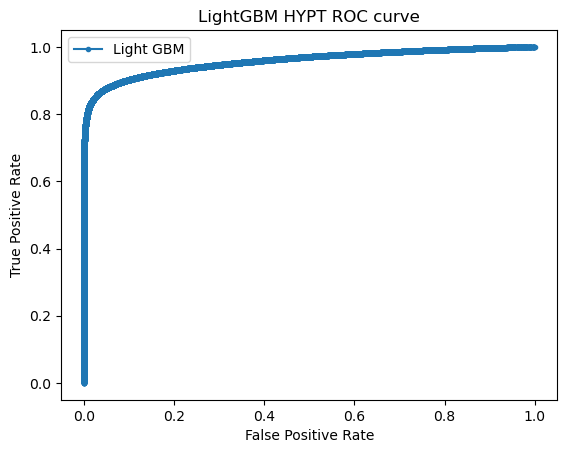

In [133]:
# calculate roc curves
lgb_hyp_fpr, lgb_hyp_tpr, _ = roc_curve(y_test, lgb_probs_hyp)
# plot the roc curve for the model
plt.plot(lgb_hyp_fpr, lgb_hyp_tpr, marker='.', label='Light GBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
plt.title('LightGBM HYPT ROC curve')
# show the plot
plt.show()

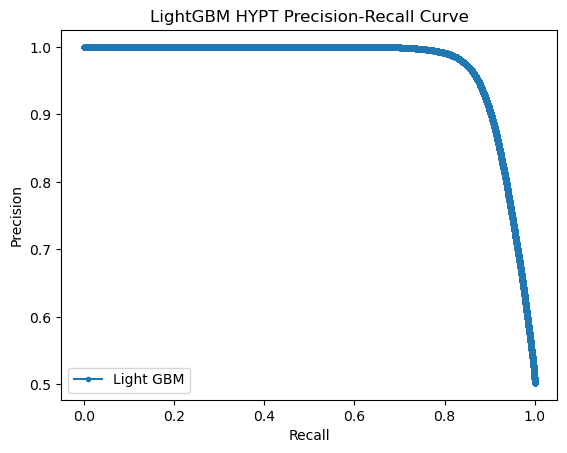

In [134]:
# calculate precision and recall for each threshold
lgb_hyp_precision, lgb_hyp_recall, _ = precision_recall_curve(y_test, lgb_probs_hyp)
plt.plot(lgb_hyp_recall, lgb_hyp_precision, marker='.', label='Light GBM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.title('LightGBM HYPT Precision-Recall Curve')
# show the plot
plt.show()

In [135]:
predictions_lgb_hyp = model_new_lgb.predict_proba(test_new_y)
df_prediction_prob = pd.DataFrame(predictions, columns = ['prob_0', 'prob_1'])
df_prediction_target = pd.DataFrame(classifier.predict(test_new_y), columns = ['predicted_TARGET'])
df_lgb_hyp = pd.concat([df_prediction_prob, df_prediction_target], axis=1)
df_lgb_hyp.sort_values(by=['prob_0'],  ascending=[False],inplace=True)
df_lgb_hyp

prob_0  prob_1  predicted_TARGET
0         1.0     0.0                 0
30464     1.0     0.0                 0
30467     1.0     0.0                 0
30468     1.0     0.0                 0
30469     1.0     0.0                 0
...       ...     ...               ...
6306      0.0     1.0                 1
34617     0.0     1.0                 1
29858     0.0     1.0                 1
6303      0.0     1.0                 1
17302     0.0     1.0                 1

[48741 rows x 3 columns]

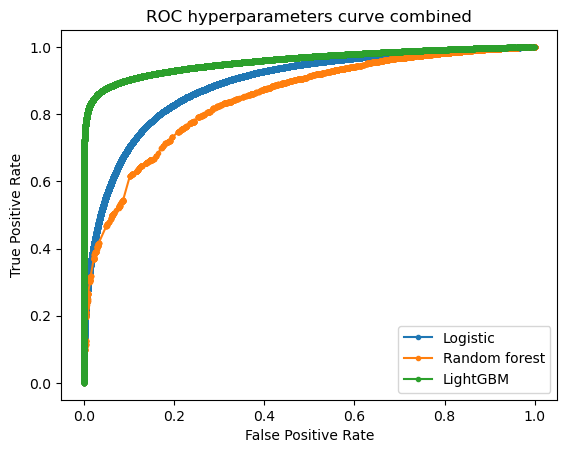

In [136]:
plt.plot(lg_hyp_fpr, lg_hyp_tpr, marker='.', label='Logistic')
plt.plot(rf_hyp_fpr, rf_hyp_tpr, marker='.', label='Random forest')
plt.plot(lgb_hyp_fpr, lgb_hyp_tpr, marker='.', label='LightGBM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC hyperparameters curve combined')
# show the legend
plt.legend()
# show the plot
plt.show()

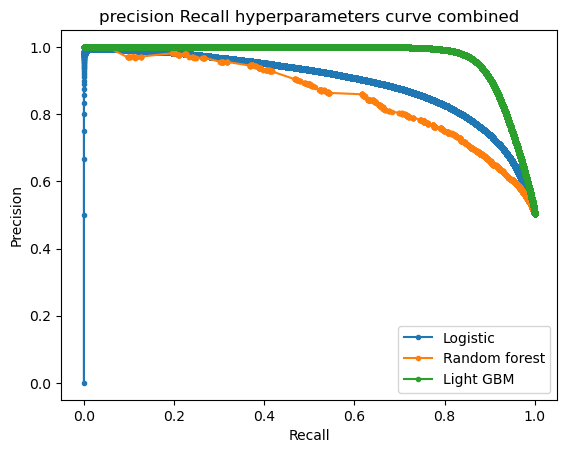

In [137]:
plt.plot(lg_hyp_recall, lg_hyp_precision, marker='.', label='Logistic')

plt.plot(rf_hyp_recall, rf_hyp_precision, marker='.', label='Random forest')

plt.plot(lgb_hyp_recall, lgb_hyp_precision, marker='.', label='Light GBM')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('precision Recall hyperparameters curve combined')
# show the legend
plt.legend()

# show the plot
plt.show()

# Conclusion

1.Simpler models are more explainable, easier to deploy than complex ones which are potential performing but complex to manage.
2.The external dataset target prediction was done with the same.
3.Detailed cleaning of data is required for better performance.